# Set Up

In [1]:
# Establish connection to drive to store dataset and trained model
from google.colab import drive
drive.mount('/content/drive')
root_path = 'drive/MyDrive/Colab Notebooks'

Mounted at /content/drive


In [2]:
# Imports
from albumentations import ElasticTransform
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image, ImageDraw, ImageFont, ImageOps
import random
import torchvision
from torchvision import transforms
from torchvision.transforms import GaussianBlur
import uuid

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
import torch
torchvision.__version__

'0.19.0+cu121'

# Dataset Curation

Dataset is curated using Google Fonts. Different font styles were downloaded that support indian languages, and their glyphs were extracted and stored in their corresponding unicode folder.

Apart from latin script and devanagari script, some commonly used symbols were also included to curate this dataset. Augmentations are applied later to create more variability in the samples.

## Dataset Generation
(To be run only once)

In [4]:
# Root directory for the dataset
dataset_dir = os.path.join(root_path, 'glyph_dataset_new')
if os.path.exists(dataset_dir):
  print("Dataset already exists")
else:
  os.makedirs(dataset_dir)

# Define Unicode ranges for special characters and Indic scripts
unicode_ranges = {
    #"latin_uppercase": (0x0041, 0x005A),
    #"latin_lowercase": (0x0061, 0x007A),
    "devanagari": (0x0900, 0x097F),  # Devanagari (Hindi, Marathi, etc.)
    #"tamil": (0x0B80, 0x0BFF),
    #"math_symbols": (0x2200, 0x22FF),
    "currency_symbols": (0x20A0, 0x20CF),
    "punctuation": (0x2000, 0x206F),
}

# Get list of all TTF files
font_folder = os.path.join(root_path, "font_styles")
font_files = [file for file in os.listdir(font_folder) if os.path.isfile(os.path.join(font_folder, file))]


Dataset already exists


In [ ]:
font_files

['OpenSans-VariableFont_wdth,wght.ttf',
 'OpenSans-Italic-VariableFont_wdth,wght.ttf',
 'NotoSans-Italic-VariableFont_wdth,wght.ttf',
 'Kalam-Regular.ttf',
 'Kalam-Light.ttf',
 'NotoSans-VariableFont_wdth,wght.ttf',
 'YatraOne-Regular.ttf',
 'Laila-Medium.ttf',
 'Laila-Regular.ttf',
 'Laila-Light.ttf',
 'Laila-SemiBold.ttf',
 'Laila-Bold.ttf',
 'Amita-Bold.ttf',
 'Akshar-VariableFont_wght.ttf',
 'Amita-Regular.ttf',
 'Ranga-Regular.ttf',
 'Ranga-Bold.ttf',
 'Handjet-VariableFont_ELGR,ELSH,wght.ttf']

In [5]:
# For each font style, generate and save images with random filenames, skipping blank ones

for font_style in font_files:
    font_path = os.path.join(font_folder, font_style)
    font = ImageFont.truetype(font_path, 64)
    for script, (start, end) in unicode_ranges.items():
        for code in range(start, end + 1):
            char = chr(code)
            unicode_str = f"U+{code:04X}"

            # Generate a random filename using UUID
            random_filename = str(uuid.uuid4()) + ".png"

            # Create an image and draw the character
            width, height = font.getsize(char)
            img = Image.new("RGB", (width+20, height+20), (255, 255, 255))
            draw = ImageDraw.Draw(img)
            draw.text((10, 10), char, font=font, fill='black')

            # Check if the character is rendered or not
            # Image is inverted to get the binding box around character if present
            invert_img = ImageOps.invert(img)
            bbox = invert_img.getbbox()
            if not (bbox is None):
              # Create directory if it doesn't exist
              char_dir = os.path.join(dataset_dir, unicode_str)
              if not os.path.exists(char_dir):
                os.makedirs(char_dir)
              # Save the image with the random filename
              img.save(os.path.join(char_dir, random_filename))

print("Dataset generated!")


<ipython-input-5-3ea7215a9830>:15: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  width, height = font.getsize(char)


Dataset generated!


# Data Augmentation

In [6]:
def randomize_glyph_color(image):
    image = image.convert("RGBA")  # Ensure image is in RGBA mode

    # Generate random color for the glyph
    r, g, b = [random.randint(0, 255) for _ in range(3)]

    # Replace the color of the glyph (assuming non-white areas are glyphs)
    def change_color(pixel):
        # Check if the pixel is a tuple (RGBA or RGB mode)
        if isinstance(pixel, tuple):
            if len(pixel) == 4:  # RGBA mode
                r_orig, g_orig, b_orig, a = pixel
                if a > 0:  # If the pixel is not fully transparent
                    return (r, g, b, a)
            elif len(pixel) == 3:  # RGB mode
                r_orig, g_orig, b_orig = pixel
                return (r, g, b)
        # If the image is in grayscale (L mode) or any other single-channel mode
        elif isinstance(pixel, int):
            return random.randint(0, 255)  # Return a random grayscale value

        return pixel  # Return the original pixel if no changes are made

    # Apply the color change to the image
    image = image.point(change_color, mode='RGBA')

    return image.convert("RGB")  # Convert back to RGB

def elastic_transform(image):
    transform = ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=None)
    augmented = transform(image=np.array(image))['image']
    return Image.fromarray(augmented)

def add_gaussian_noise(image):
    img_array = np.array(image)
    mean = 0
    stddev = 10
    gaussian = np.random.normal(mean, stddev, img_array.shape)
    noisy_image = img_array + gaussian
    noisy_image = np.clip(noisy_image, 0, 255)
    return Image.fromarray(noisy_image.astype('uint8'))

def change_background_color(image, color):
    image = image.convert("RGBA")
    background = Image.new('RGBA', image.size, color)
    combined = Image.alpha_composite(background, image)
    return combined.convert("RGB")

# Random background color augmentation
def random_bg_color(image):
    random_color = tuple(np.random.randint(0, 256, size=3))  # Random RGB color
    return change_background_color(image, random_color)

# Define augmentation pipeline
augmentations = transforms.Compose([
    transforms.RandomApply([transforms.Lambda(random_bg_color)], p=0.4),
    transforms.RandomApply([transforms.Lambda(lambda img: randomize_glyph_color(img))], p=0.5),
    transforms.RandomApply([transforms.Lambda(lambda img: elastic_transform(img))], p=0.2),
    transforms.RandomApply([transforms.Lambda(lambda img: add_gaussian_noise(img))], p=0.5),
    transforms.RandomApply([GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0))], p=0.3),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.3, contrast=0.3)], p=0.5),
    transforms.RandomApply([transforms.Resize((128, 128))], p=1),
    transforms.RandomApply([transforms.RandomRotation(degrees=(-15, 15))], p=0.3),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.2),
    transforms.RandomApply([transforms.Lambda(lambda img: img.convert("RGB").point(lambda p: p * random.uniform(0.5, 1.5)))], p=0.4),
    transforms.ToTensor()
])


In [7]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Root directory for the dataset
dataset_dir = os.path.join(root_path, 'glyph_dataset')

# Assuming your dataset is loaded using ImageFolder
dataset = ImageFolder(root=dataset_dir, transform=augmentations)

# Define a DataLoader to load the augmented data
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


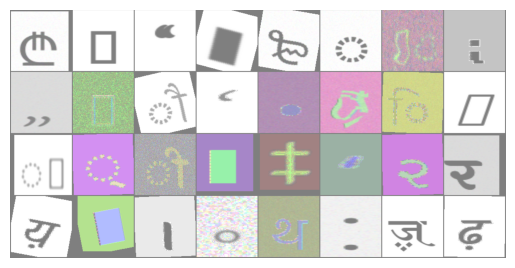

In [8]:
# Visualise some of the images to see how augmented ones look like
# Get a batch of images
data_iter = iter(dataloader)
labels, images = next(data_iter)  # Assuming labels are available as well

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize if you normalized your images earlier
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Hide axis
    plt.show()

# Get a batch of images
for images, labels in dataloader:
    # Create a grid from the batch
    img_grid = torchvision.utils.make_grid(images)
    # Display the grid
    imshow(img_grid)
    break  # Show only the first batch

In [9]:
print(f"The number of classes in our dataset: {len(dataset.classes)}")
print(f"The number of samples in our dataset: {len(dataset)}")

The number of classes in our dataset: 249
The number of samples in our dataset: 3241


Sample Code for loading dataset with augmentations, splitting it into train and test, and creating dataloaders for training and evaluation

In [ ]:
from torch.utils.data import Subset, DataLoader

# Root directory for the dataset
dataset_dir = os.path.join(root_path, 'glyph_dataset')
dataset = ImageFolder(root=dataset_dir, transform=augmentations)

# Generate indices
indices = np.arange(len(dataset))
np.random.shuffle(indices)

# Define split
split = int(0.8 * len(dataset))  # 80% for training
train_indices, test_indices = indices[:split], indices[split:]

# Create subsets
train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)


# Dataset from TMNIST

TMNIST and TALPHA dataset

In [ ]:
%cd /content

/content


In [ ]:
!unzip archive_talpha.zip

Archive:  archive_talpha.zip
  inflating: 94_character_TMNIST.csv  


In [ ]:
import os
import pandas as pd


In [ ]:
# Location of the csv file
# /content/drive/MyDrive/Colab Notebooks/Glyphs_TMNIST_updated.csv
csv_file = os.path.join(root_path, '94_character_TMNIST.csv')

df = pd.read_csv(csv_file)
df.head()

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,Salsa-Regular,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MouseMemoirs-Regular,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Creepster-Regular,f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SeoulNamsan-Light,/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HachiMaruPop-Regular,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Get total number of samples
print(f"Total number of samples: {len(df)}")
# Get total number of unique values in column 'glyph_name'
print(f"Total number of unique glyphs: {len(df['glyph_name'].unique())}")

Total number of samples: 565292
Total number of unique glyphs: 1819


In [ ]:
# Get number of samples for each unique 'glyph_name'
df['glyph_name'].value_counts()

,count
glyph_name,
APOSTROPHE,3005
QUOTATION MARK,3004
DIGIT TWO,2990
DIGIT SEVEN,2990
DIGIT THREE,2990
...,...
TIBETAN LETTER SA,2
TIBETAN LETTER SHA,2
TIBETAN LETTER LA,2


<Axes: xlabel='glyph_name'>

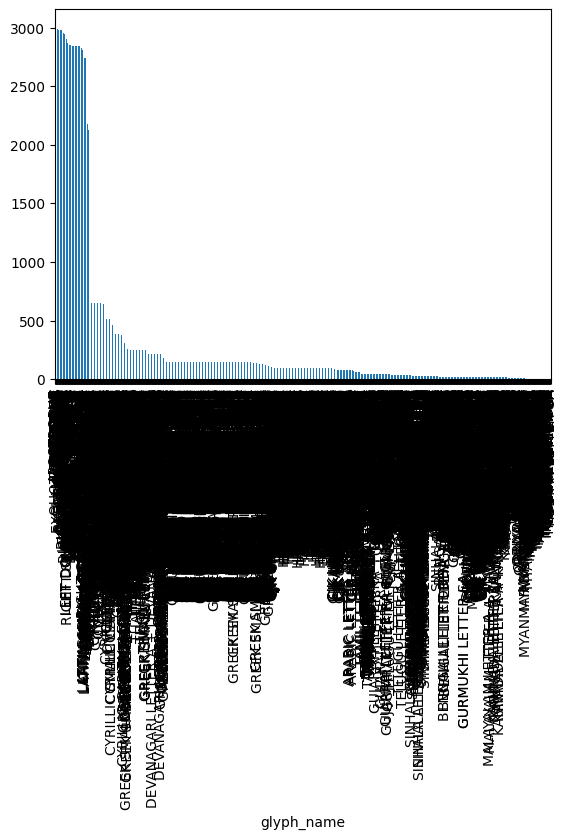

In [ ]:
# Save g
df['glyph_name'].value_counts().plot(kind='bar')

In [ ]:
# Define Unicode ranges for special characters and Indic scripts
unicode_ranges = {
    "latin_uppercase": (0x0041, 0x005A),
    "latin_lowercase": (0x0061, 0x007A),
    "devanagari": (0x0900, 0x097F),  # Devanagari (Hindi, Marathi, etc.)
    #"tamil": (0x0B80, 0x0BFF),
    "math_symbols": (0x2200, 0x22FF),
    "currency_symbols": (0x20A0, 0x20CF),
    "punctuation": (0x2000, 0x206F),
}

useful_unicodes = []
for script, (start, end) in unicode_ranges.items():
        for code in range(start, end + 1):
            char = chr(code)
            unicode_str = f"0x{code:04X}"
            useful_unicodes.append(unicode_str)

In [ ]:
print(useful_unicodes)

['0x0041', '0x0042', '0x0043', '0x0044', '0x0045', '0x0046', '0x0047', '0x0048', '0x0049', '0x004A', '0x004B', '0x004C', '0x004D', '0x004E', '0x004F', '0x0050', '0x0051', '0x0052', '0x0053', '0x0054', '0x0055', '0x0056', '0x0057', '0x0058', '0x0059', '0x005A', '0x0061', '0x0062', '0x0063', '0x0064', '0x0065', '0x0066', '0x0067', '0x0068', '0x0069', '0x006A', '0x006B', '0x006C', '0x006D', '0x006E', '0x006F', '0x0070', '0x0071', '0x0072', '0x0073', '0x0074', '0x0075', '0x0076', '0x0077', '0x0078', '0x0079', '0x007A', '0x0900', '0x0901', '0x0902', '0x0903', '0x0904', '0x0905', '0x0906', '0x0907', '0x0908', '0x0909', '0x090A', '0x090B', '0x090C', '0x090D', '0x090E', '0x090F', '0x0910', '0x0911', '0x0912', '0x0913', '0x0914', '0x0915', '0x0916', '0x0917', '0x0918', '0x0919', '0x091A', '0x091B', '0x091C', '0x091D', '0x091E', '0x091F', '0x0920', '0x0921', '0x0922', '0x0923', '0x0924', '0x0925', '0x0926', '0x0927', '0x0928', '0x0929', '0x092A', '0x092B', '0x092C', '0x092D', '0x092E', '0x092F',

In [ ]:
# There is a lot class imbalance. let us start by filtering out samples that we dont need
# Using label column in df, get all unique labels and then find and store corresponding hex unicode for them
label_list = df['label'].unique()
useful_labels = []
tmp = []
for label in label_list:
  hex_code = f"0x{ord(label[0]):04X}"
  tmp.append(hex_code)
  if hex_code in useful_unicodes:
    useful_labels.append(label)


In [ ]:
print(useful_labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '‘', '’', '“', '”', '€', '₹', '₪', 'आ', 'ई', 'ऊ', 'ऋ', 'ॠ', 'ऌ', 'ॡ', 'ऐ', 'औ', 'ऎ', 'अं', 'अँ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'य', 'र', 'व', 'ळ', 'श', 'ष', 'स', 'ह', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९']


In [ ]:
if "0x0954" in useful_unicodes:
  print("yes")

yes


In [ ]:
df.label[1159][1]

'ං'

In [ ]:
# Exyract samples with useful_labels in them

filtered_df = df[df['label'].isin(useful_labels)]
filtered_df = filtered_df.drop(columns=['font_name', 'glyph_name'])
# Print length of filtered df
print(f"Length of filtered df: {len(filtered_df)}")

Length of filtered df: 175445


In [ ]:
filtered_df.head()

,label,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,D,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Get number of samples for each unique 'glyph_name'
filtered_df['label'].value_counts()

,count
label,
“,2874
”,2873
‘,2867
E,2853
e,2853
...,...
ञ,216
ट,216
ठ,216


In [ ]:
filtered_df.to_csv('filtered_df.csv', index=False)

In [ ]:
import unicodedata

glyph_letter = "DEVANAGARI LETTER A"
glyph_matra = "DEVANAGARI SIGN ANUSVARA"
unicode_letter = unicodedata.lookup(glyph_letter)
# Get the hex code for the unicode_letter
unicode_letter_hex = f"0x{ord(unicode_letter):04x}"
unicode_matra = unicodedata.lookup(glyph_matra)
# Get the hex code for the unicode_matra
unicode_matra_hex = f"0x{ord(unicode_matra):04x}"
print(unicode_letter_hex, unicode_matra_hex)

0x0905 0x0902


In [ ]:
# Using hexcode of a chracter, print the actual chracter
print(chr(int(unicode_letter_hex, 16)) + chr(int(unicode_matra_hex, 16)))

अं


In [ ]:
combined_letter = chr(int(unicode_letter_hex, 16)) + chr(int(unicode_matra_hex, 16))
print(combined_letter)


अं


In [ ]:
combined_letter_hex = hex(ord(combined_letter[1]))
print(combined_letter_hex)


0x902


In [ ]:
import os
import pandas as pd
alpha_csv_file = os.path.join(root_path, 'alpha.csv')
tmp_df = pd.read_csv(alpha_csv_file)

In [ ]:
tmp_df.head()

,labels,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import unicodedata
# Get unique labels from new_df
unique_labels_df = tmp_df['labels'].unique().tolist()
print("Unique labels in alpha csv:", unique_labels_df)

# Get a list of labels we dont want
unicode_ranges = {
    "latin_uppercase": (0x0041, 0x005A),
    "latin_lowercase": (0x0061, 0x007A),
}

latin_alphas = []
for script, (start, end) in unicode_ranges.items():
    for code in range(start, end + 1):
        unicode_character = chr(int(code))
        latin_alphas.append(unicode_character)

print("Latin alphas to remove: ", latin_alphas)

Unique labels in alpha csv: ['6', 'D', 'f', '/', 'F', 'x', 'J', '8', 'H', 'k', '@', '1', '=', 'g', ')', '2', 'd', '^', '3', 't', '#', '.', '4', 'o', '"', 'y', 'A', 'u', 'G', '-', 'm', 'W', '&', 'c', '9', 'N', ']', 'P', 'X', '|', '}', 'h', '7', 'j', '5', '>', '?', 'b', '*', 'w', 'l', '0', '$', 'I', 'Y', '%', ':', 'T', 'K', 'E', '<', 'V', '{', 'M', 'S', 'a', 'i', 'r', "'", 'p', ';', '[', '+', 'e', 'U', '(', 's', '~', ',', 'C', 'q', '_', 'n', 'B', 'z', 'v', 'O', 'R', '`', 'Z', 'Q', 'L', '!', '\\']
Latin alphas to remove:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
# Save samples for punctuation and special characters in another df
# Do this by filtering out samples from tmp_df that have label in latin_alphas
spl_char_df = tmp_df[~tmp_df['labels'].isin(latin_alphas)]
print("Labels in spl_char_df: ", spl_char_df['labels'].unique().tolist())

# Change column name labels to label in spl_char_df
spl_char_df = spl_char_df.rename(columns={'labels': 'label'})
# Save spl_char_df to a csv file
spl_char_df.to_csv('spl_char_df.csv', index=False)

Labels in spl_char_df:  ['6', '/', '8', '@', '1', '=', ')', '2', '^', '3', '#', '.', '4', '"', '-', '&', '9', ']', '|', '}', '7', '5', '>', '?', '*', '0', '$', '%', ':', '<', '{', "'", ';', '[', '+', '(', '~', ',', '_', '`', '!', '\\']


In [ ]:
# Load filtered_df.csv and combine it with spl_char_df
import os
import pandas as pd
filtered_df_file = os.path.join(root_path, 'filtered_df.csv')
filtered_df = pd.read_csv(filtered_df_file)

# Combine filtered_df and spl_char_df into a single dataframe
combined_df = pd.concat([filtered_df, spl_char_df], ignore_index=True)

# Save combined_df to a csv
combined_df.to_csv('combined_df.csv', index=False)

In [ ]:
# Construct and save images as glyphs from combined_df
import pandas as pd
import numpy as np
from PIL import Image
import os
import uuid

# Load the combined_df.csv file
csv_path = os.path.join(root_path, 'spl_char_df.csv')
combined_df = pd.read_csv(csv_path)
# Directory to save images
output_dir = os.path.join(root_path, 'glyph_images')
os.makedirs(output_dir, exist_ok=True)

In [ ]:
import uuid
# Iterate over each row in the DataFrame
for index, row in combined_df.iterrows():
    # Reshape the 784 pixel values into a 28x28 array
    pixel_values = row[1:].values.astype(np.uint8).reshape((28, 28))

    # Create an image from the array
    img = Image.fromarray(pixel_values, mode='L')  # 'L' mode is for grayscale

    # Generate random image file name using UUID
    random_filename = str(uuid.uuid4()) + ".png"

    label = row['label']

    if label not in ['\'', '\"']:
      # Create a directory for each font if needed
      label_dir = os.path.join(output_dir, label)
      os.makedirs(label_dir, exist_ok=True)

      # Save the image
      img_path = os.path.join(label_dir, f'{random_filename}')
      img.save(img_path)

print(f'Images saved in {output_dir} directory.')

Images saved in drive/MyDrive/Colab Notebooks/glyph_images directory.


In [ ]:
del combined_df
import gc
gc.collect()


55366

In [ ]:
%cd /content

/content


In [ ]:
!ls

'!'   +   '>'   _    ’	  0   ३   7   A   dot   h   K   o   R   v   Y   ऊ   औ   छ   ढ   प   व
'#'   ,   '?'  '`'   “	  ०   4   ७   b   e     H   l   O   s   V   z   ऋ   क   ज   ण   फ   श
 %    -    @   '{'   ”	  1   ४   8   B   E     i   L   p   S   w   Z   ॠ   ख   झ   त   ब   ष
'&'   :   '['  '|'  '$'   १   5   ८   c   f     I   m   P   t   W   अँ   ऌ   ग   ञ   थ   भ   स
'('  ';'  '\'  '}'   ₪	  2   ५   9   C   F     j   M   q   T   x   अं   ॡ   घ   ट   द   य   ह
')'  '<'   ]   '~'   €	  २   6   ९   d   g     J   n   Q   u   X   आ   ऎ   ङ   ठ   ध   र
'*'  '='  '^'   ‘    ₹	  3   ६   a   D   G     k   N   r   U   y   ई   ऐ   च   ड   न   ळ


## Load Dataset

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
# Load dataset from glyph_images using imagefolder for multiclass classification
dataset_dir = os.path.join(root_path, 'glyph_images')
dataset = ImageFolder(root=dataset_dir)

In [ ]:
print(f"The number of classes in our dataset: {len(dataset.classes)}")
print(f"The number of samples in our dataset: {len(dataset)}")

The number of classes in our dataset: 152
The number of samples in our dataset: 218253


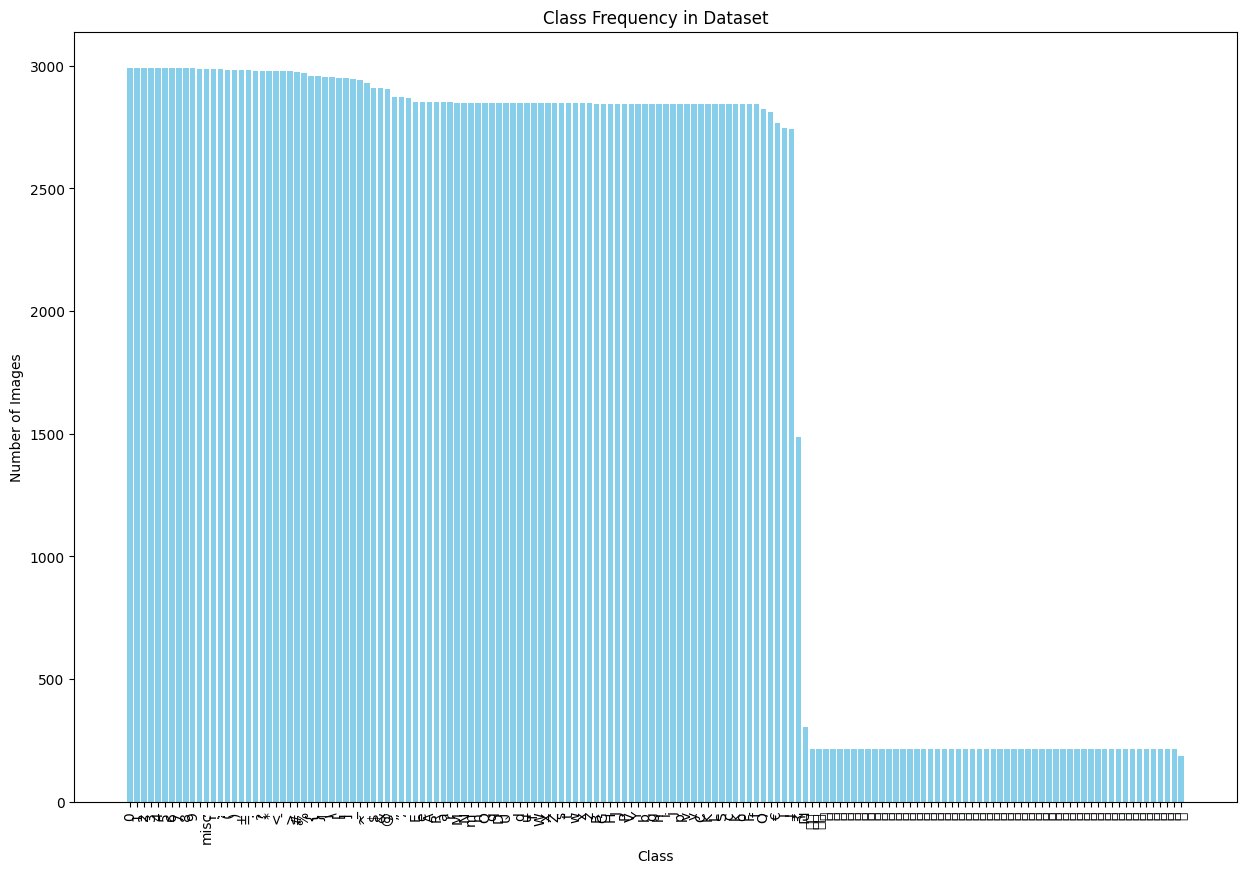

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Get the labels (numeric) for each image in the dataset
labels = [label for _, label in dataset.imgs]

# Count the frequency of each label
label_counts = Counter(labels)

# Get the class names from the dataset
class_names = {v: k for k, v in dataset.class_to_idx.items()}

# Convert numeric labels back to class names
class_counts = {class_names[k]: v for k, v in label_counts.items()}

# Sort classes by frequency
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

# Plot the class frequencies
plt.figure(figsize=(15, 10))
plt.bar(range(len(sorted_class_counts)), list(sorted_class_counts.values()), tick_label=list(sorted_class_counts.keys()), color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Frequency in Dataset')
plt.show()


In [ ]:
from collections import Counter
import random

# Step 1: Count the number of samples for each class
labels = [label for _, label in dataset.imgs]
label_counts = Counter(labels)

# Step 2: Filter and balance the dataset
balanced_imgs = []

for label, count in label_counts.items():
    if count > 100:
        # Get all images for this label
        img_paths = [(img_path, lbl) for img_path, lbl in dataset.imgs if lbl == label]
        # Randomly select 300 images
        selected_imgs = random.sample(img_paths, 100)
        balanced_imgs.extend(selected_imgs)
    else:
        # If the class has 300 or fewer samples, include all
        img_paths = [(img_path, lbl) for img_path, lbl in dataset.imgs if lbl == label]
        balanced_imgs.extend(img_paths)

# Step 3: Create a new balanced dataset
balanced_dataset = [(img_path, lbl) for img_path, lbl in balanced_imgs]

# Verify the balance by counting again
balanced_label_counts = Counter([lbl for _, lbl in balanced_dataset])
for label, count in balanced_label_counts.items():
    print(f'Class: {dataset.classes[label]}, Number of samples: {count}')


Class: !, Number of samples: 100
Class: #, Number of samples: 100
Class: $, Number of samples: 100
Class: %, Number of samples: 100
Class: &, Number of samples: 100
Class: (, Number of samples: 100
Class: ), Number of samples: 100
Class: *, Number of samples: 100
Class: +, Number of samples: 100
Class: ,, Number of samples: 100
Class: -, Number of samples: 100
Class: 0, Number of samples: 100
Class: 1, Number of samples: 100
Class: 2, Number of samples: 100
Class: 3, Number of samples: 100
Class: 4, Number of samples: 100
Class: 5, Number of samples: 100
Class: 6, Number of samples: 100
Class: 7, Number of samples: 100
Class: 8, Number of samples: 100
Class: 9, Number of samples: 100
Class: :, Number of samples: 100
Class: ;, Number of samples: 100
Class: <, Number of samples: 100
Class: =, Number of samples: 100
Class: >, Number of samples: 100
Class: ?, Number of samples: 100
Class: @, Number of samples: 100
Class: A, Number of samples: 100
Class: B, Number of samples: 100
Class: C, 

In [ ]:
# Save for easy reload
import pickle

# Save balanced dataset to a pickle file
pickle_file = os.path.join(root_path, 'balanced_dataset_100.pkl')

with open(pickle_file, 'wb') as file:
    pickle.dump(balanced_dataset, file)

print(f"Balanced dataset saved to {pickle_file}.")


Balanced dataset saved to drive/MyDrive/Colab Notebooks/balanced_dataset_100.pkl.


In [ ]:
# Convert it into an ImageFolder Dataset
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, img_paths_labels, transform=None):
        self.img_paths_labels = img_paths_labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_paths_labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([transforms.ToTensor()])

'''
Augmentations to be added later dependin on model performance

transform = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),  # Random crop and resize to 28x28
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(10),  # Random rotation by ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the image
])
'''
balanced_custom_dataset = CustomImageDataset(balanced_dataset, transform=transform)


In [ ]:
# Before we can use this dataset for fine-tuning VLP, we must update class name

dot_idx = dataset.class_to_idx['dot']
new_class_name = '.'

# Remove the old 'dot' entry and add new class name at same idx
del dataset.class_to_idx['dot']
dataset.class_to_idx[new_class_name] = dot_idx

# Update the class names list
dataset.classes[dot_idx] = new_class_name

KeyError: 'dot'

In [ ]:
balanced_dataset = [
    (img_path, dot_idx if label == dot_idx else label)
    for img_path, label in balanced_dataset
]

In [ ]:
balanced_custom_dataset = CustomImageDataset(balanced_dataset, transform=transform)

In [ ]:
import pickle

# Define the file path to save the dataset
pickle_file = 'balanced_custom_dataset.pkl'

# Save the custom balanced dataset as a pickle file
with open(pickle_file, 'wb') as f:
    pickle.dump(balanced_custom_dataset.img_paths_labels, f)

print(f"Balanced custom dataset saved to {pickle_file}.")

Balanced custom dataset saved to balanced_custom_dataset.pkl.


In [ ]:
import pickle
with open('balanced_custom_dataset.pkl', 'rb') as f:
    img_paths_labels = pickle.load(f)

balanced_custom_dataset = CustomImageDataset(img_paths_labels, transform=transform)


# Hindi Letter x Matra dataset

In [ ]:
# Let us now add hindi letter x matra combined characters
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageFont

# List of Devanagari base letters and matras
base_letters = ['क', 'ख', 'ग', 'घ', 'च', 'छ', 'ज', 'झ', 'ट', 'ठ',
                'ड', 'ढ', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब',
                'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह']

matras = ['ा', 'ि', 'ी', 'ु', 'ू', 'े', 'ै', 'ो', 'ौ', 'ं', 'ः']

# Path to a Devanagari font file (.ttf or .otf)
font_path = 'path/to/Devanagari-font.ttf'  # Update this with the correct path to your Devanagari font file

# Initialize a list to store the flattened images
data = []

# Create a 28x28 grayscale image for each combination
for base in base_letters:
    for matra in matras:
        combined_char = base + matra

        # Create a blank 28x28 grayscale image
        image = Image.new('L', (28, 28), color=255)  # 'L' mode is for grayscale

        # Load the font and set the size
        font = ImageFont.truetype(font_path, 24)  # Adjust the font size if needed

        # Create a drawing context
        draw = ImageDraw.Draw(image)

        # Calculate the position to center the text
        text_size = draw.textsize(combined_char, font=font)
        position = ((28 - text_size[0]) // 2, (28 - text_size[1]) // 2)

        # Draw the text onto the image
        draw.text(position, combined_char, fill=0, font=font)

        # Resize to 28x28 pixels (already set, but for safety)
        image = image.resize((28, 28))

        # Flatten the image into a 1D array
        flattened_image = np.array(image).flatten()

        # Store the label and flattened image
        row = [combined_char] + flattened_image.tolist()
        data.append(row)

# Create a DataFrame from the data
columns = ['label'] + [str(i) for i in range(1, 785)]
df_combined = pd.DataFrame(data, columns=columns)

# Save to a CSV file (optional)
df_combined.to_csv('combined_characters.csv', index=False)


# Glyph Extraxtion from PDF

In [ ]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 21.1 MB/s eta 0:00:00


In [ ]:
import fitz  # PyMuPDF
import torch
from PIL import Image
from torchvision import transforms

def extract_glyphs_from_pdf(pdf_path):
    pdf_document = fitz.open(pdf_path)
    glyph_images = []

    for page_num in range(len(pdf_document)):
        page = pdf_document[page_num]
        blocks = page.get_text("dict")["blocks"]

        for block in blocks:
            if "lines" in block:
                for line in block["lines"]:
                    for span in line["spans"]:
                        bbox = span["bbox"]

                        # Extract glyph image from bounding box
                        x0, y0, x1, y1 = bbox
                        rect = fitz.Rect(x0, y0, x1, y1)
                        pix = page.get_pixmap(clip=rect)

                        # Convert pixmap to PIL Image
                        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
                        glyph_images.append(img)

    return glyph_images

def classify_glyphs(glyph_images, model, transform):
    classified_text = ""

    for img in glyph_images:
        img = transform(img).unsqueeze(0)  # Apply transformations and add batch dimension
        with torch.no_grad():
            output = model(img)
            _, predicted = torch.max(output, 1)
            unicode_char = chr(predicted.item())
            classified_text += unicode_char

    return classified_text

def save_classified_text(text, output_path):
    with open(output_path, "w", encoding="utf-8") as f:
        f.write(text)
    print(f"Classified text saved to {output_path}")

# Example usage
pdf_path = "./hindi_text_file.pdf"
output_path = "hindi_text.txt"


In [ ]:
glyph_images = extract_glyphs_from_pdf(pdf_path)

In [ ]:
glyph_images[11]